# Analysis of JPMAP iterations
You must first run JPMAP with `--save-iters` flag to store JPMAP iterations (see `run_experiments.sh`)

In [48]:
import os
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
import torch
from utils import *
from hdn_utils import load_hdn_model, dec_pass
import pickle as pkl

# For LaTeX in matplotlib figures
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cpu


## Load experiments parameters

In [49]:
exp_name = 'hdn_denoising_128_csgm-opti-stepbystep'  # see "run_experiments.sh"
experiment = os.path.join('experiments/celeba-wb', exp_name)

In [50]:
with open(os.path.join(experiment, 'experiment_args.json')) as json_file:
    args = json.load(json_file)

    #alpha = args['alpha']*np.sqrt(n_pixels)/255
    model = args['model']
    n_samples = args['n_samples']

In [51]:
with open(os.path.join(experiment, 'mse_results.json')) as json_file:
    args = json.load(json_file)
    print(args)

{'csgm': [0.008929625153541565, 0.0051086232997477055, 0.004008737858384848], 'jpmap': [0.11726520210504532, 0.1182788610458374, 0.08816835284233093]}


In [46]:
models_folder = 'pretrained_models'
model_path = os.path.join(models_folder, model)
hdn = load_hdn_model(model_path, device=device)

## Show results

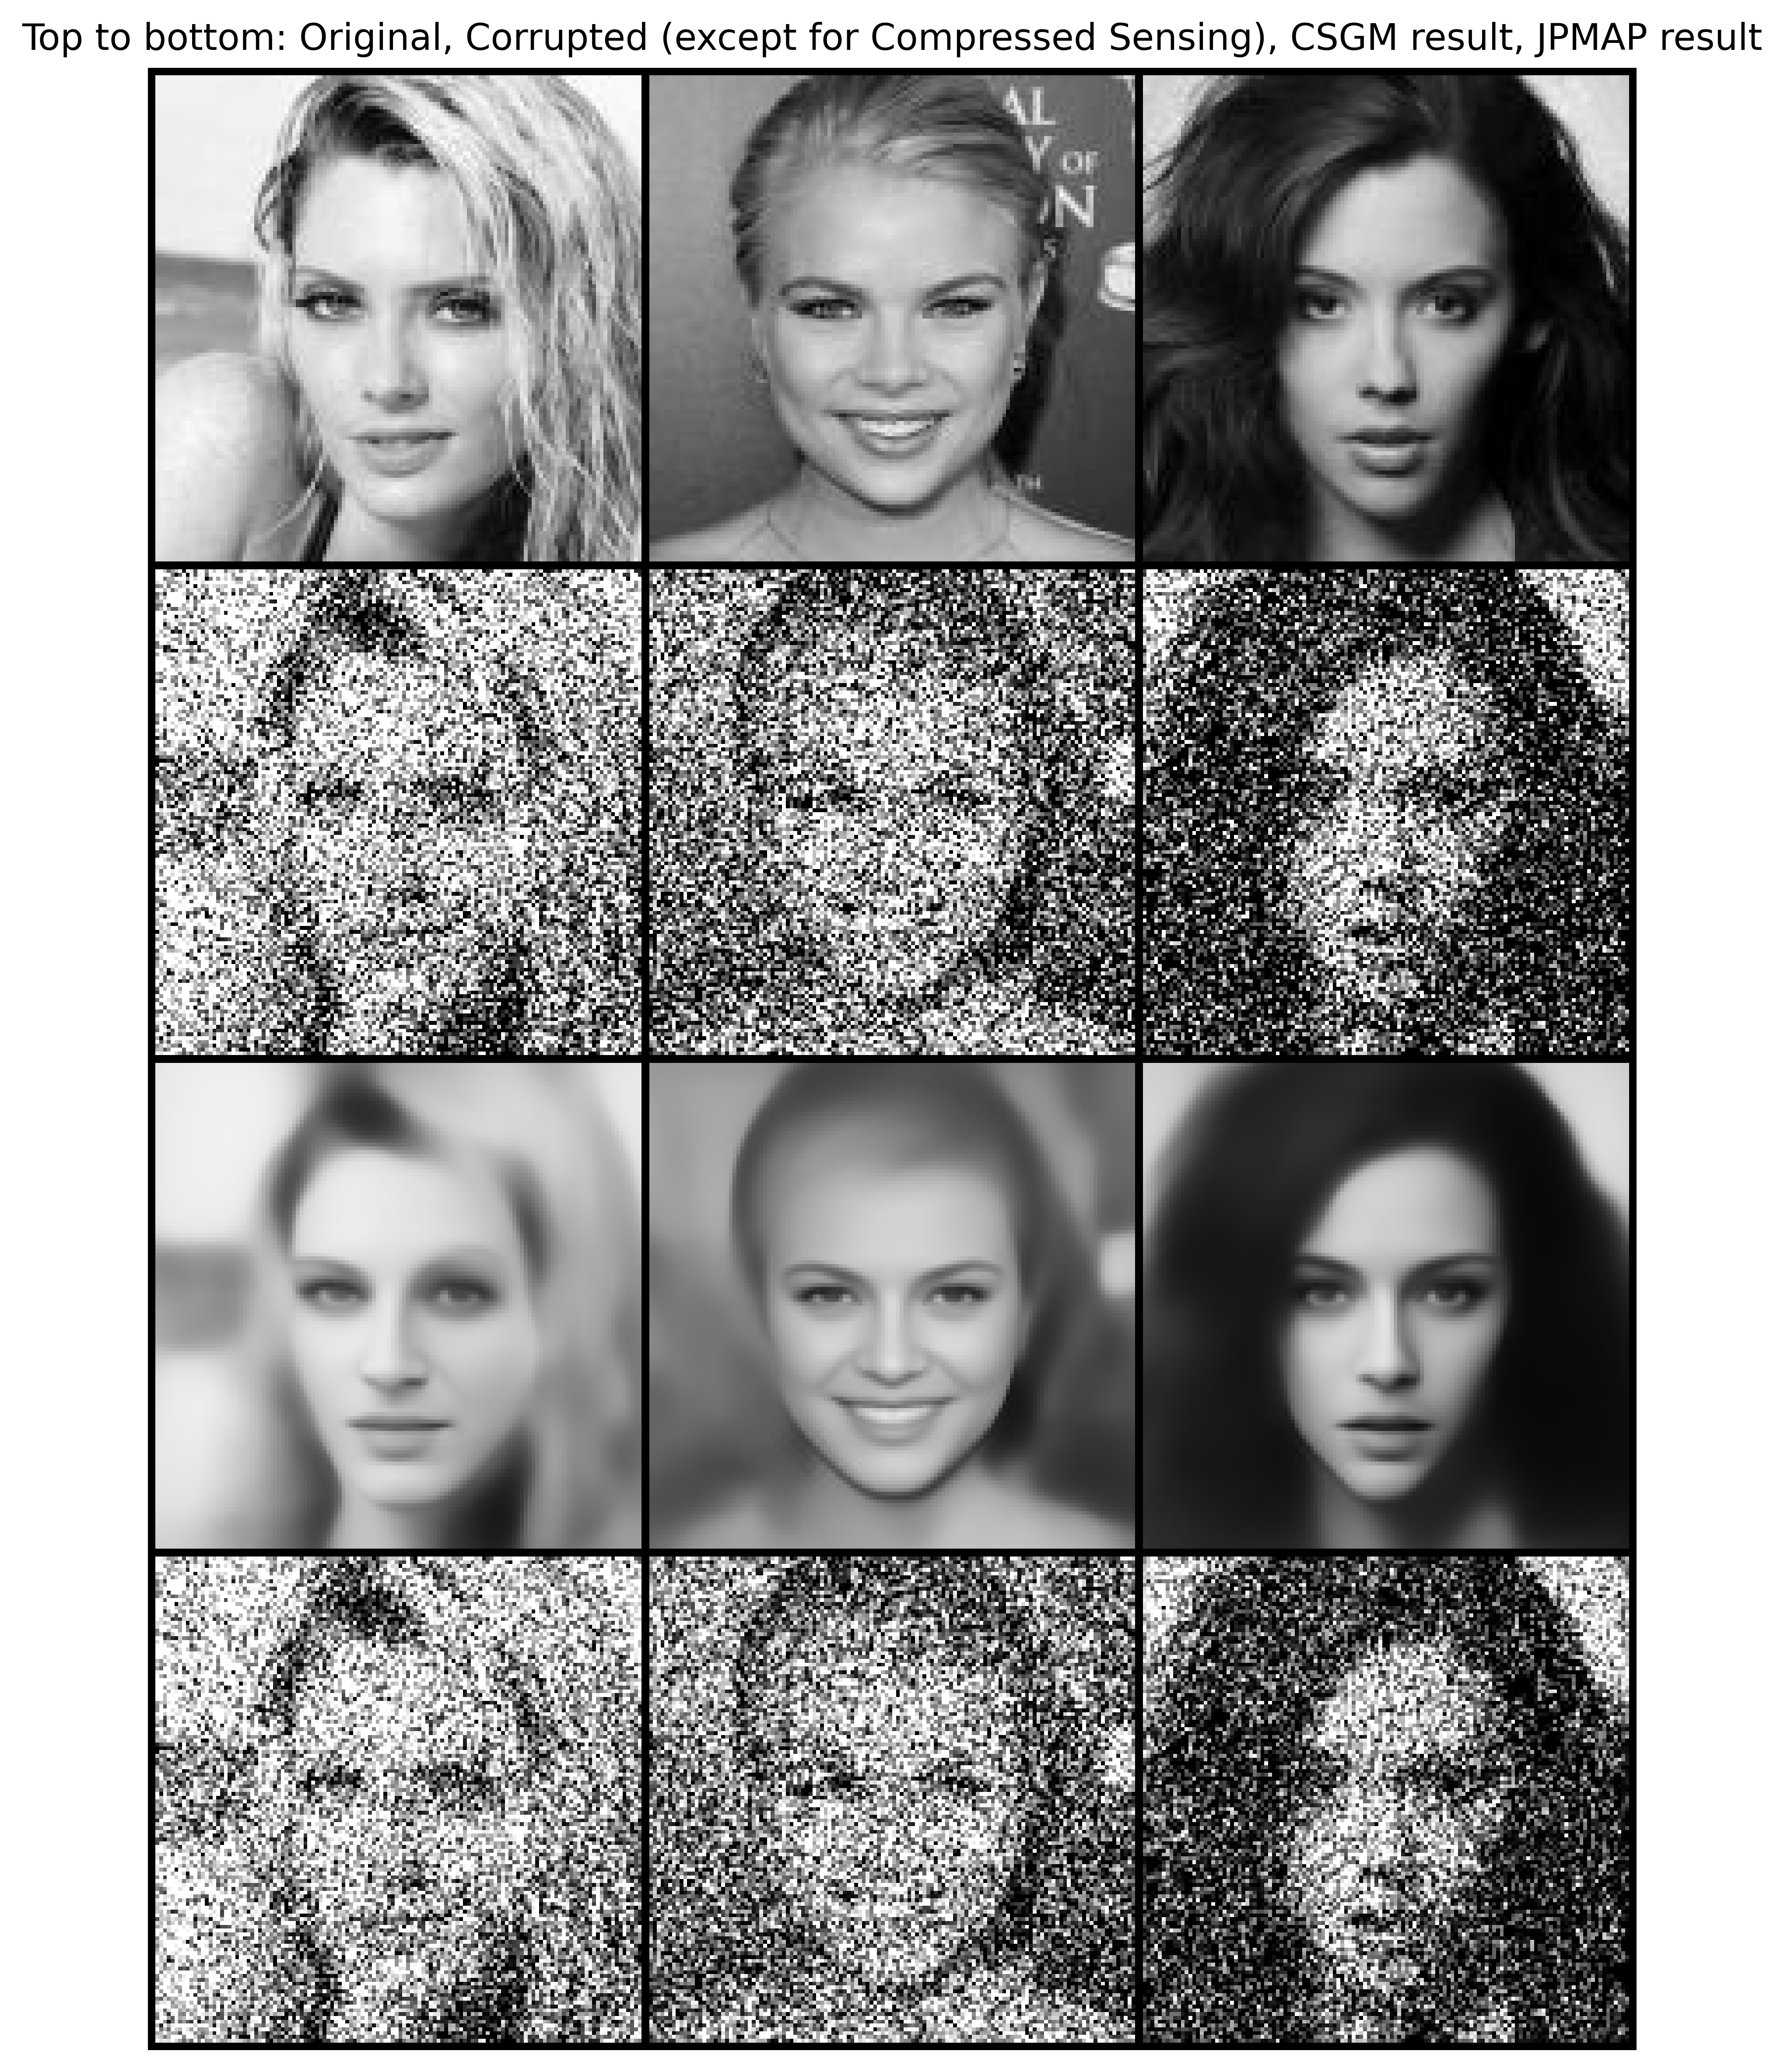

In [52]:
results = plt.imread(os.path.join(experiment, 'results_' + exp_name + '.png'))
plt.figure(figsize=(12,12), dpi=500)
plt.imshow(results); plt.axis('off');
plt.title('Top to bottom: Original, Corrupted (except for Compressed Sensing), CSGM result, JPMAP result');

## Load one restoration

In [53]:
print('Number of samples =', n_samples)

Number of samples = 3


In [54]:
ind = 0  # between 0 and (n_samples-1)
xiters_jpmap = np.load(os.path.join(experiment, 'xiters_jpmap_%2d.npy' % ind))
with open(os.path.join(experiment, 'ziters_jpmap_%2d.pkl' % ind), 'rb') as f:
    ziters_jpmap = pkl.load(f)
#ziters_jpmap = np.load(os.path.join(experiment, 'ziters_jpmap_%2d.npy' % ind))
#n_pixels = xiters_jpmap[0].size

In [55]:
ziters_jpmap_pytorch = [torch.from_numpy(ziters_jpmap[i]) for i in range(len(ziters_jpmap))]
mu_x, data = dec_pass(ziters_jpmap_pytorch, hdn, device, (128,128), True)

#mu_x, gamma_x = vae.decoder(torch.from_numpy(ziters_jpmap).to(device))
Gziters_jpmap = mu_x.cpu().detach().numpy()
# print('gamma_x =', float(gamma_x))

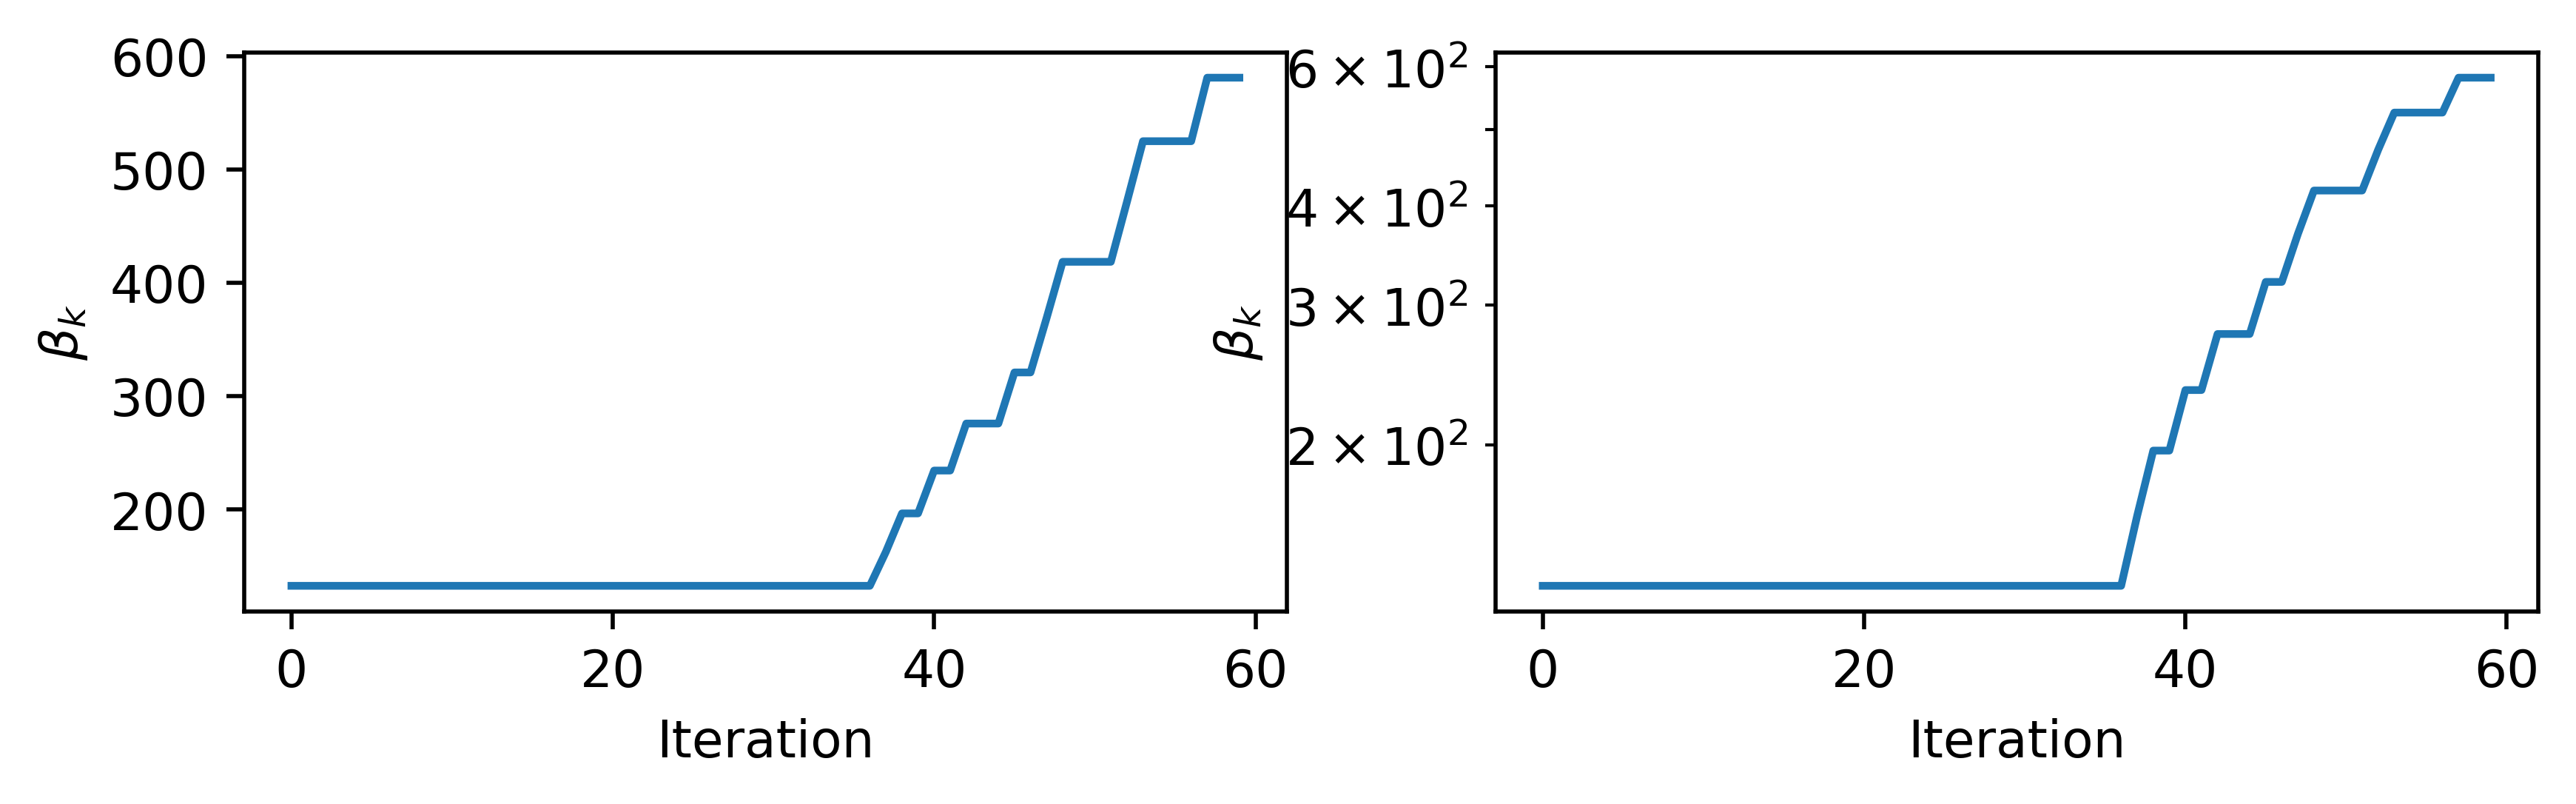

In [34]:
beta_k = np.load(os.path.join(experiment, 'beta_k_%2d.npy' % ind), allow_pickle=True)
#gamma_k = 1/beta_k
plt.figure(figsize=(8,2), dpi=500)
plt.subplot(121), plt.plot(beta_k), plt.xlabel('Iteration'), plt.ylabel('$\\beta_k$');
plt.subplot(122), plt.semilogy(beta_k), plt.xlabel('Iteration'), plt.ylabel('$\\beta_k$');
#plt.subplot(223), plt.plot(gamma_k), plt.xlabel('Iteration'), plt.ylabel('$\gamma_k$');
#plt.subplot(224), plt.semilogy(gamma_k), plt.xlabel('Iteration'), plt.ylabel('$\gamma_k$');

## Plot `xiters`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


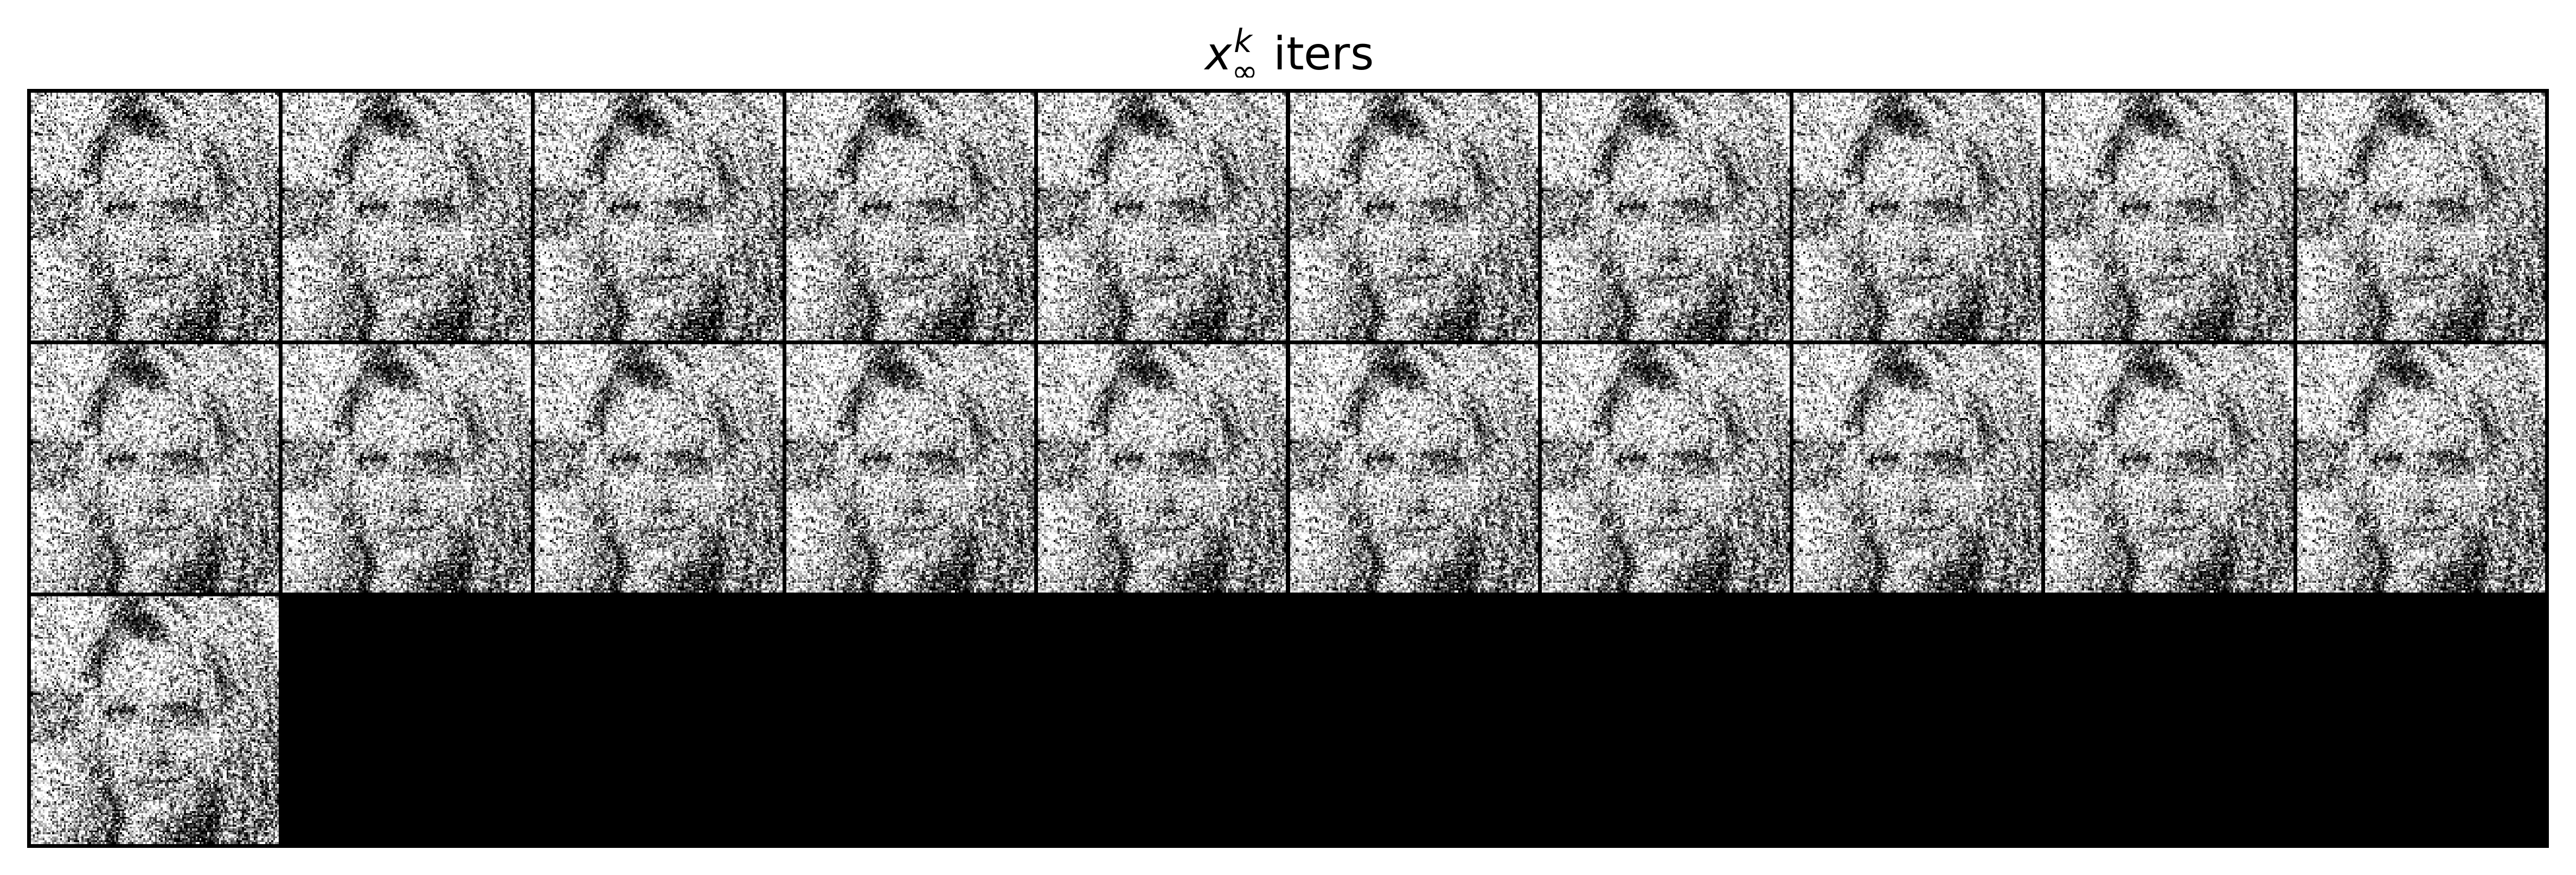

In [56]:
xiters_jpmap = torch.unsqueeze(torch.from_numpy(xiters_jpmap), dim=1)
show_image = make_grid(xiters_jpmap, nrow=10).permute(1,2,0)
plt.figure(figsize=(12,12), dpi=500)
plt.imshow(show_image);
plt.title('$x^k_\infty$ iters');
plt.axis('off');

## Images generated by `ziters`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


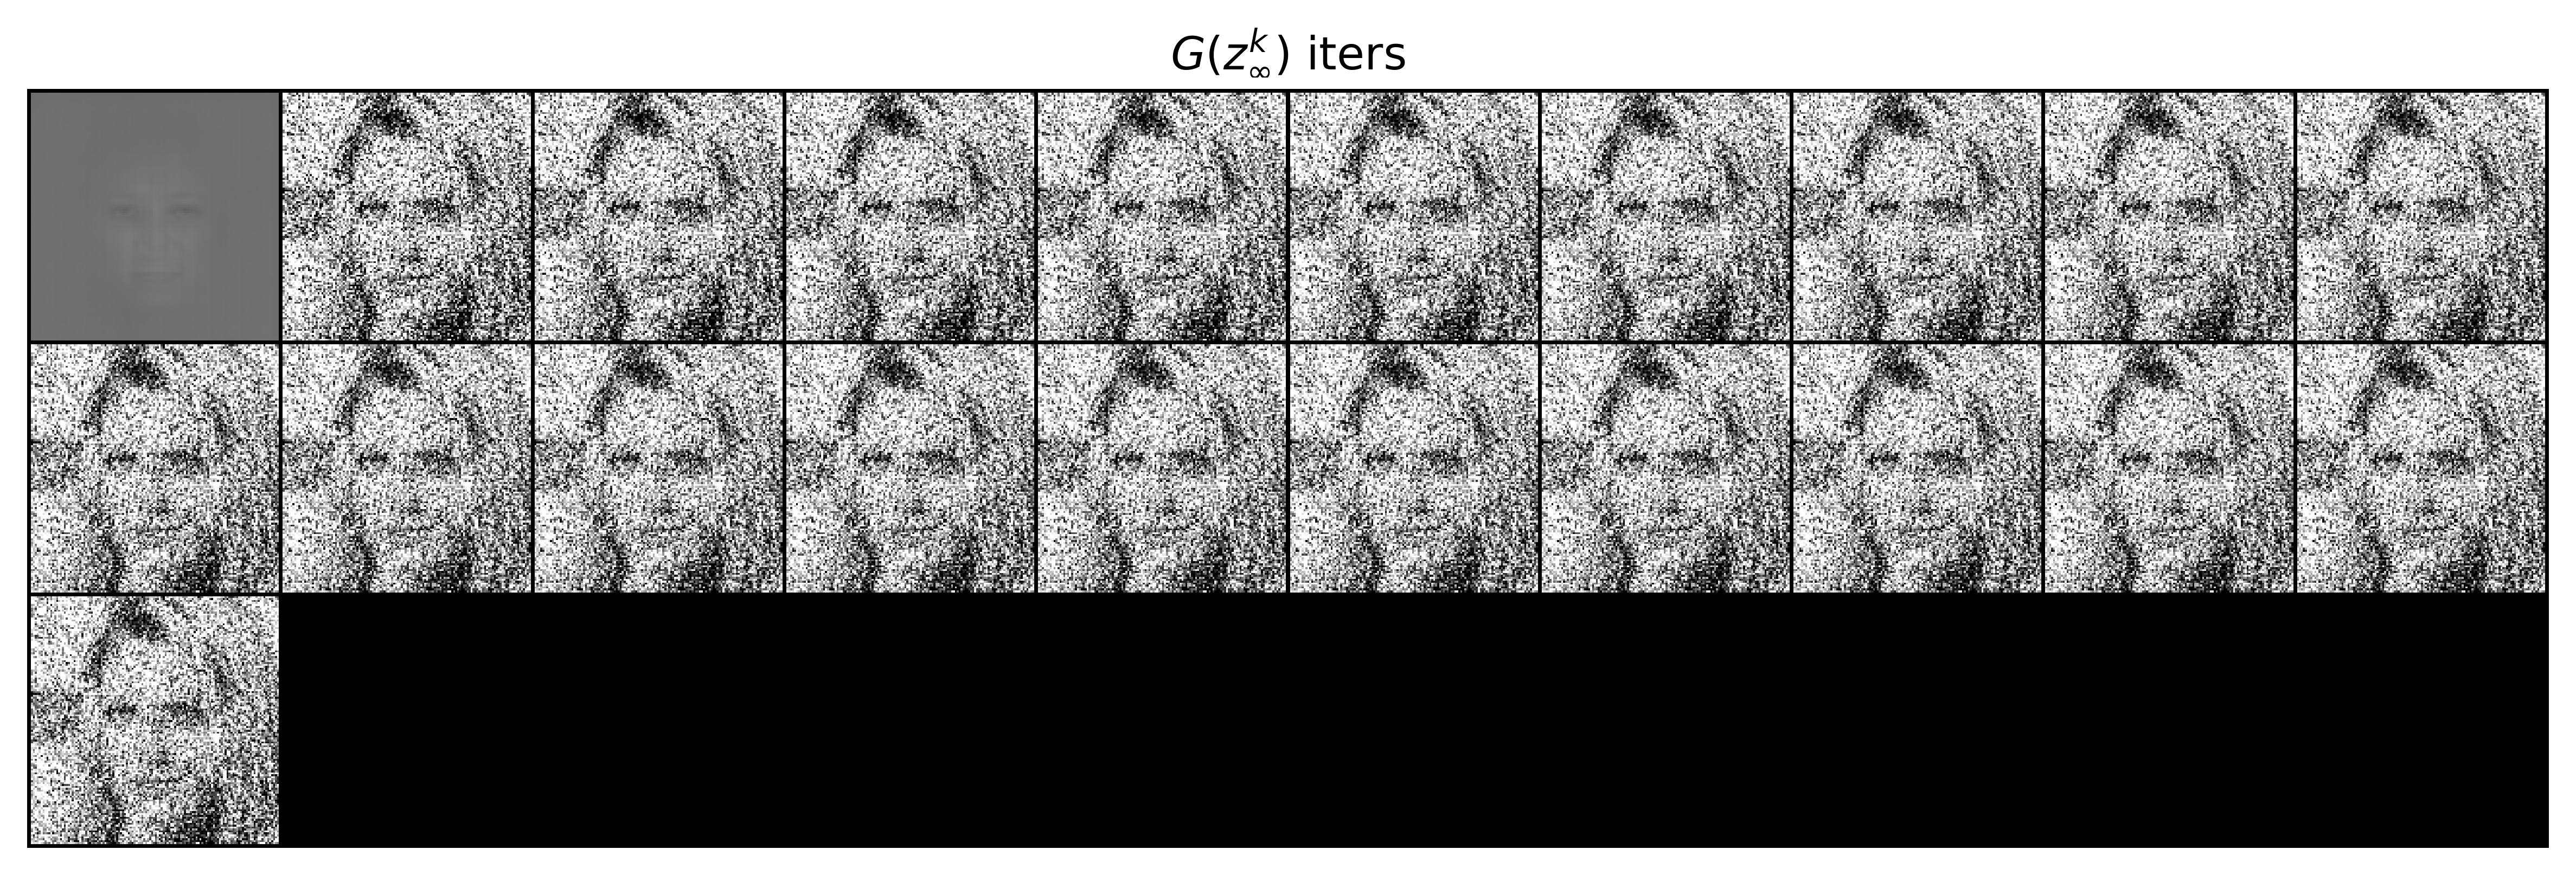

In [57]:
show_image2 = make_grid(torch.from_numpy(Gziters_jpmap), nrow=10).permute(1,2,0)
plt.figure(figsize=(12,12), dpi=500)
plt.imshow(show_image2);
plt.title('$G(z^k_\infty)$ iters')
plt.axis('off');

## Distances

[53.954144   2.0025349  2.1328115  1.9753892  1.9081737 21.329391
 20.962229  18.133856  15.554834  13.468154  11.782259  10.427158
  9.347122   8.495063   7.8272243  7.3069277  6.9093385  6.610107
  6.388342   6.22676    6.108504   6.0241904  5.9625278  5.9193325
  5.8872876  5.8635125  5.847677   5.8367147  5.827328   5.8215733
  5.8165555  5.81517    5.8127785  5.8126225  5.8079076  5.8048573
  5.8024073  5.586696   5.3737254  5.3911014  5.1716504  5.1903596
  4.9707785  4.990975   5.0050883  4.783286   4.801915   4.576079
  4.384335   4.4085193  4.4259725  4.4399323  4.2309837  4.0563903
  4.0774927  4.093471   4.106829   3.930774   3.9467213  3.9467213]


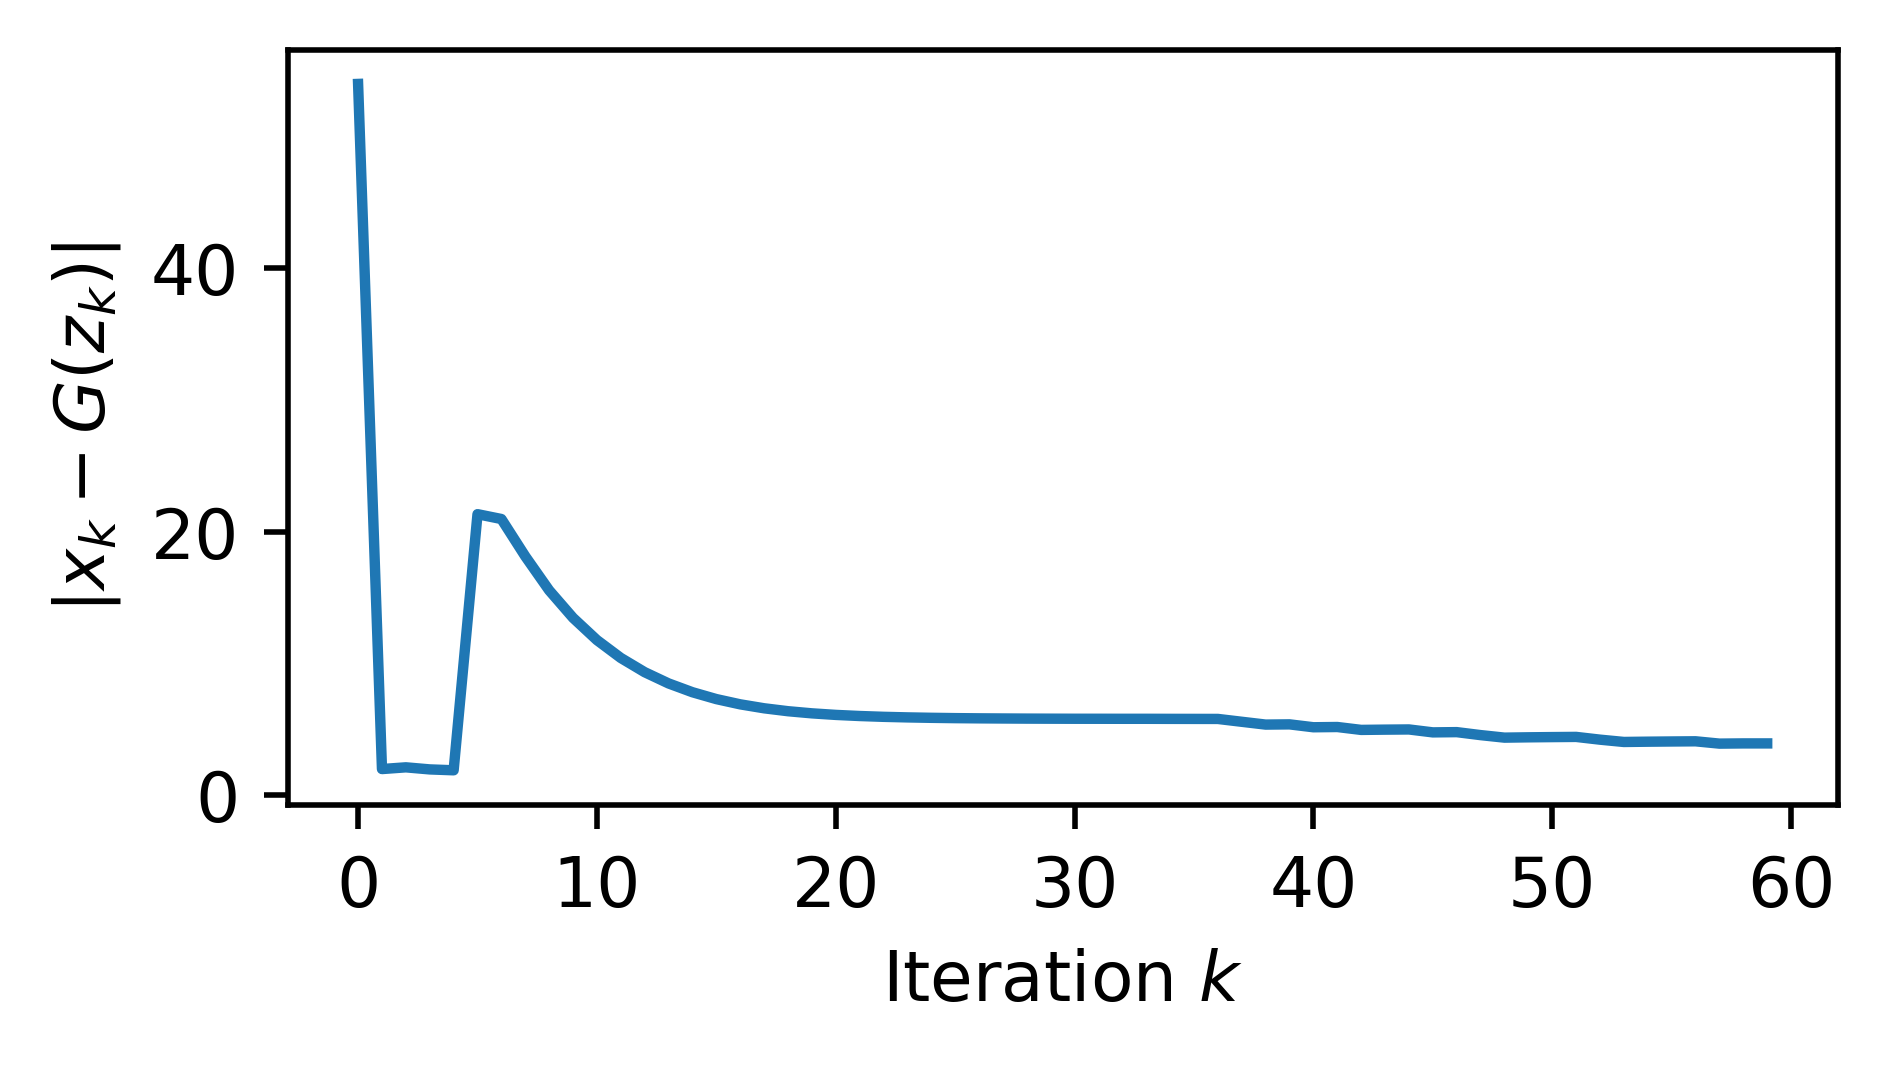

In [37]:
n = xiters_jpmap.shape[0]
dif = (Gziters_jpmap-xiters_jpmap.cpu().detach().numpy()).reshape(n,-1)
norms = norm(dif, axis=1)

plt.figure(figsize=(4,2), dpi=500)
plt.plot(norms);
plt.xlabel('Iteration $k$');
plt.ylabel('$\|x_k - G(z_k)\|$');
print(norms)